<a href="https://colab.research.google.com/github/mohitin/IMAGE-PROCESSING/blob/main/213070021_IP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##                               IMAGE PROCESSING (EE610) - ASSIGNMENT 2
Mohit Kumar Meena \
213070021

## Importing required libraries

In [ ]:
#importing libraries
import numpy as np
import pandas as pd
import glob
import cv2
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.feature_extraction.image import extract_patches_2d
%matplotlib inline

## mounting the dataset from google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/Colab Notebooks/images/train'

images_all = []

for i in os.scandir(path):
  images_all.append(i.path)
#reading original images
import matplotlib.pyplot as plt
from matplotlib import image
images_input=[]
for i in range(200):
    img=image.imread(images_all[i])
    images_input.append(img)

Mounted at /content/drive


## Degrading original images by blurring and adding noises

In [ ]:
#adding salt and peeper noise to the blurred images
#Reference: [1]
def add_noise(img):
        # Getting the dimensions of the image
        row , col, channels = img.shape
        # Pick a random number between 100 and 1000
        number_of_pixels = random.randint(100, 1000)
        for i in range(number_of_pixels):
                # Pick a random y coordinate
                y_coord=random.randint(0, row - 1)
                # Pick a random x coordinate
                x_coord=random.randint(0, col - 1)
                # Color that pixel to white
                img[y_coord][x_coord] = 255
        # Pick a random number between 100 and 1000
        number_of_pixels = random.randint(100 , 1000)
        for i in range(number_of_pixels):
                # Pick a random y coordinate
                y_coord=random.randint(0, row - 1)
                # Pick a random x coordinate
                x_coord=random.randint(0, col - 1)
                # Color that pixel to black
                img[y_coord][x_coord] = 0
        return img
#degrading original images
pass1_gaussian=[]
pass2_median=[]
pass3_noise=[]
#step1--> degrading by gaussian blur
for i in range(len(images_input)):
               Gaussian=cv2.GaussianBlur(images_input[i],(11,11),0)
               pass1_gaussian.append(Gaussian)
#step2--> degrading by median blur
for j in range(len(pass1_gaussian)):
               median=cv2.medianBlur(pass1_gaussian[j],11)
               pass2_median.append(median)
#step3--> degrading by adding salt and peeper noise
for k in range(len(pass2_median)):
    salt_peeper=add_noise(pass2_median[k])
    pass3_noise.append(salt_peeper)

## Displaying output to compare original vs degraded

Text(0.5, 1.0, 'Degraded Image')

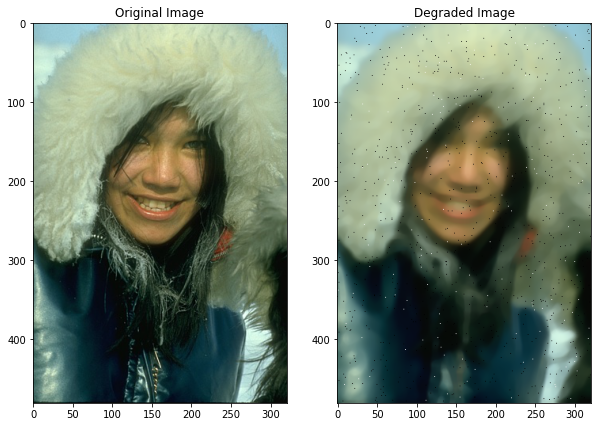

In [ ]:
#displaying output
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(images_input[10]) #40 is the random number
plt.title('Original Image')
plt.subplot(1,2,2)
plt.imshow(pass3_noise[10])
plt.title("Degraded Image")

  Extracting patches from degraded images and central pixel from original image

In [ ]:
#extracting the patch from degraded image
#Reference2: [2]
patch_degraded=[]
for i in range(len(pass3_noise)):
    temp=pass3_noise[i].reshape(1,321,481,3)
    patch1=tf.image.extract_patches(images=temp,
                               sizes=[1, 23, 23, 1],
                               strides=[1, 23, 23, 1],
                               rates=[1, 1, 1, 1],
                               padding='VALID')
#     temp2=np.array(patch1)
    temp3=tf.reshape(patch1,(-1,23,23,3))
    patch_degraded.append(temp3)
#extracting the central pixel from original image
central_pixel=[]
for j in range(len(images_input)):
    temp4=images_input[j].reshape(1,321,481,3)
    patch2=tf.image.extract_patches(images=temp4,
                               sizes=[1, 23, 23, 1],
                               strides=[1, 23, 23, 1],
                               rates=[1, 1, 1, 1],
                               padding='VALID')
    temp6=tf.reshape(patch2,(-1,23,23,3))
#     central_pixel.append(temp6)
    
#     temp5=np.array(patch2)
#     temp6=temp5.reshape(-1,23,23,3)
    for k in range(260):
        temp7=temp6[k][11][11]
        central_pixel.append(temp7)
#     central = temp6[:,11,11,:]
#     central = np.reshape(central,(-1,3))
central_pixel=np.asarray(central_pixel)   
central_pixel=central_pixel.reshape(-1,3)
patch_degraded=np.asarray(patch_degraded)
#reshaping the degraded patch into required demension (data_size,fetaure_Size)
patch_degraded=patch_degraded.reshape(-1,23*23*3)

Output of patches from degraded and original images

Y shape: (1, 1, 3) X shape: (23, 23, 3)


Text(0.5, 1.0, 'Central Pixel of original image')

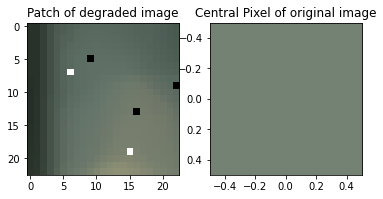

In [17]:
X_temp = patch_degraded[300,:]
X_temp = np.reshape(X_temp,(23,23,3))
Y_temp = central_pixel[300,:]
Y_temp = np.reshape(Y_temp,(1,1,3))
print(f'Y shape: {Y_temp.shape} X shape: {X_temp.shape}')
plt.subplot(1,2,1)
plt.imshow(X_temp)
plt.title('Patch of degraded image')
plt.subplot(1,2,2)
plt.imshow(Y_temp)
plt.title('Central Pixel of original image')

## Training ANN model (TensorFlow backend)
Number of hidden layers=2\
Number of neurons in hidden layer= 90 (each) \
Number of features=1587 $(23*23*3)$  \
Number of training instances= 52000 $(260*200)$


In [8]:
#importing libraries for training model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(patch_degraded, central_pixel, test_size=0.20, random_state=101)
model=Sequential()
model.add(Dense(patch_degraded.shape[1], activation='relu', input_dim = patch_degraded.shape[1]))
model.add(Dense(80,activation='relu')) 
model.add(Dense(80,activation='relu'))
model.add(Dense(3,activation='relu'))
model.compile(optimizer='Adam',loss='mse')
import time
start_time = time.time()
model.fit(x=X_train,y=y_train,validation_data=(X_test,y_test),batch_size=64,epochs=150)
duration=(time.time()-start_time)/60
print(f'\nDuration: {duration:.2f} minutes')
pd=model.predict(X_test)
rmse1=np.sqrt(mean_squared_error(y_test,pd))
print('RMSE: ',rmse1 )


Epoch 1/150
650/650 [==============================] - 22s 32ms/step - loss: 10738.5537 - val_loss: 10129.3350
Epoch 2/150
650/650 [==============================] - 21s 32ms/step - loss: 10058.6904 - val_loss: 10069.9404
Epoch 3/150
650/650 [==============================] - 21s 32ms/step - loss: 10022.5186 - val_loss: 10053.0479
Epoch 4/150
650/650 [==============================] - 21s 32ms/step - loss: 10011.2959 - val_loss: 10048.7168
Epoch 5/150
650/650 [==============================] - 21s 32ms/step - loss: 10018.5869 - val_loss: 10123.8838
Epoch 6/150
650/650 [==============================] - 21s 32ms/step - loss: 10009.5059 - val_loss: 10125.7686
Epoch 7/150
650/650 [==============================] - 21s 32ms/step - loss: 10011.3818 - val_loss: 10048.9219
Epoch 8/150
650/650 [==============================] - 20s 31ms/step - loss: 10028.1475 - val_loss: 10074.2842
Epoch 9/150
650/650 [==============================] - 20s 31ms/step - loss: 6671.6670 - val_loss: 4679.9248
Epo

## Training the Random Forest Regressor

In [9]:
from sklearn.ensemble import RandomForestRegressor
#training model for first 10000 training examples only
model2 =RandomForestRegressor(n_estimators=10,criterion='mse')
model2.fit(X_train[0:10000,:],y_train[0:10000,:])
pd2=model2.predict(X_test[0:1000,:])
y_test2=y_test[0:1000,:]
rmse2=np.sqrt(mean_squared_error(y_test2,pd2))
print('RMSE: ',rmse2 )

RMSE:  22.055317423847402


## Regenerating the images using trained model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Reconstructed Image 3')

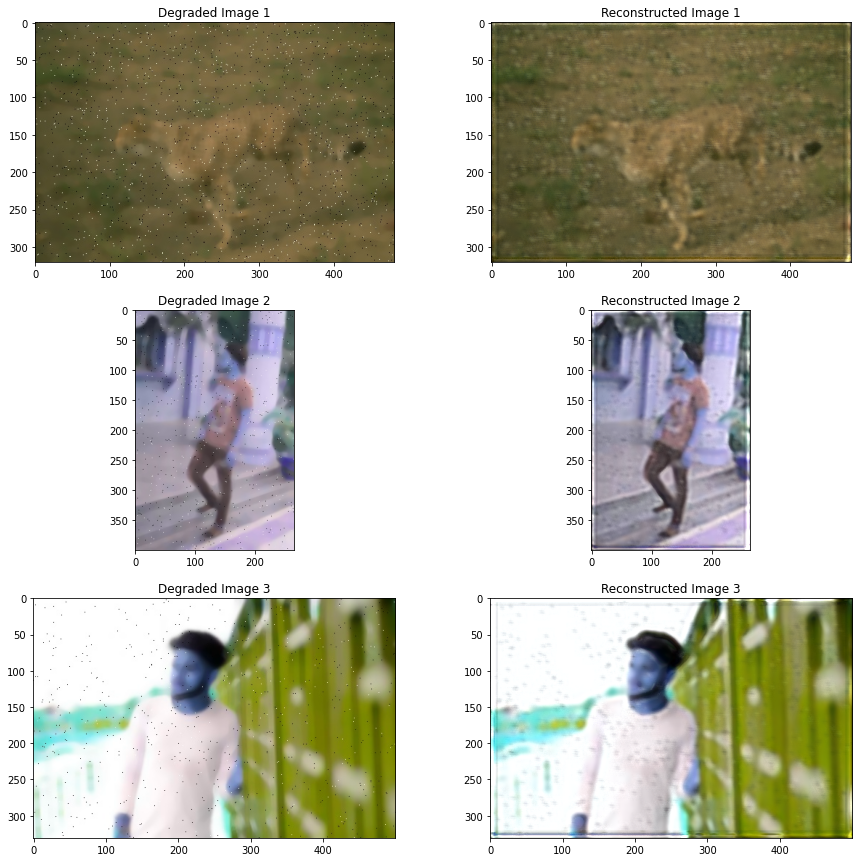

In [16]:
test1=cv2.imread('/content/image_025.jpg')
test2=cv2.imread('/content/mine01.jpg')
test3=cv2.imread('/content/mine02.jpg')
k=23 #patch_size
#fucntion to reconstruct the image
def reconstruct(image_original):
    a,b=image_original.shape[0],image_original.shape[1]
    image_original=np.reshape(image_original,(1,a,b,3))
    degraded=tf.image.extract_patches(image_original,sizes=[1,k,k,1],strides=[1,1,1,1],rates=[1,1,1,1],padding='SAME') 
    degraded=tf.reshape(degraded,(-1,k,k,3)) #SAME PADDING above is used to avoid dimension error
    temp1=np.asarray(tf.reshape(degraded,(-1,k*k*3)))
    print(temp1.shape)
    temp2=model.predict(temp1)
    temp2=(temp2).astype(int)
    print(temp2.shape)
    temp2=np.reshape(temp2,(a,b,3))
    return temp2
#comparing output of original images and predicted image
final1=reconstruct(test1)
final2=reconstruct(test2)
final3=reconstruct(test3)
#plotting the results using matplotlib
plt.figure(figsize=(15,15))
plt.subplot(3,2,1)
plt.imshow(test1)
plt.title('Degraded Image 1')
plt.subplot(3,2,2)
plt.imshow(final1)
plt.title('Reconstructed Image 1')
plt.subplot(3,2,3)
plt.imshow(test2)
plt.title('Degraded Image 2')
plt.subplot(3,2,4)
plt.imshow(final2)
plt.title('Reconstructed Image 2')
plt.subplot(3,2,5)
plt.imshow(test3)
plt.title('Degraded Image 3')
plt.subplot(3,2,6)
plt.imshow(final3)
plt.title('Reconstructed Image 3')


## Coclusions: 
1. Degrading the images 
 *  Increasing the kernel size will increase the intensity of blurring.
 *  Salt and peeper noise introduces more error than gaussian noise.
 *  Reconstruction of images is tough if median blurring is introduced.
2. Extracting patches
 *  Increasing the size of patches will increase the number of features.
 *  If SAME padding is used then ghost edges are introduced.
 *  Model will overfit if patch size is smaller since training instances increases.
 *  Input to the tensorflow is a 4D tensor.
3. Training ANN model
 *  Increasing the number of neurons above 100 will lead to overfit the model.
 * Increasing the batch_size will increase error.
 * Adam optimizer gave the best performance for this model.
 * Increasing the number of hidden layers will slightly reduce validation loss but significantly increase training time [3].
4. Training Random Forest Model
  * On using entire training set, it took plenty of time to train the model.
  * The n_estimator has to less to avoid overfitting.
  * validation error is slighlty greater than the ANN model because of using less training instances to train the model.
5. Image Reconstruction
 * Model is working fine to reduce noise but couldn't deblur upto good extent.
 * If the image is highly degraded then results are poor.
 * CNN model is not used as advised by Amit Sethi Sir. 


## References : 
1.  https://www.geeksforgeeks.org/add-a-salt-and-pepper-noise-to-an-image-with-python/

2. https://www.tensorflow.org/api_docs/python/tf/image/extract_patches

3. https://www.heatonresearch.com/2017/06/01/hidden-layershtml#:~:text=Using%20too%20many%20neurons%20in,layers%20may%20result%20in%20overfitting.&text=An%20inordinately%20large%20number%20of,takes%20to%20train%20the%20network.

## Discussion :
 1. Nihar Gupte (213070002)
 2. Harsh Diwaker (213070018)